## Imports & Settings

In [284]:
import warnings
warnings.filterwarnings('ignore')

In [285]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [286]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [287]:
DATA_STORE = '../00_data/assets_v1.h5'
START = '2000-01-01'

## Load Stock Data

In [288]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['stocks/prices/daily']).loc[idx[:, :], 'adjusted_close'].unstack(0)
    stocks = store['stocks/base_fundementals']

In [289]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15392 entries, 1962-01-02 to 2023-02-22
Columns: 503 entries, AAPL to NWS
dtypes: float64(503)
memory usage: 59.2+ MB


In [290]:
stocks['AAPL']['General']

Code                                                                  AAPL
Type                                                          Common Stock
Name                                                             Apple Inc
Exchange                                                            NASDAQ
CurrencyCode                                                           USD
CurrencyName                                                     US Dollar
CurrencySymbol                                                           $
CountryName                                                            USA
CountryISO                                                              US
ISIN                                                          US0378331005
LEI                                                   HWUPKR0MPOU8FGXBT394
CUSIP                                                            037833100
CIK                                                                 320193
EmployerIdNumber         

## Data Cleaning

In [291]:
stocks1 = pd.DataFrame(stocks.loc[idx[:, 'General', 'Sector']], columns= ['Sector'])
stocks2 = pd.DataFrame(stocks.loc[idx[:, 'General', 'IPODate']], columns= ['IPODate'])
stocks3 = pd.DataFrame(stocks.loc[idx[:, 'Highlights', 'MarketCapitalization']], columns= ['MarketCapitalization'])

stocks = pd.concat([stocks1, stocks2, stocks3], axis=1)

In [292]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'
shared = prices.columns.intersection(stocks.index)

In [293]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, AAPL to NWS
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Sector                503 non-null    object
 1   IPODate               503 non-null    object
 2   MarketCapitalization  503 non-null    object
dtypes: object(3)
memory usage: 31.9+ KB


In [294]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15392 entries, 1962-01-02 to 2023-02-22
Columns: 503 entries, AAPL to NWS
dtypes: float64(503)
memory usage: 59.2+ MB


In [295]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

In [296]:
prices.index = pd.to_datetime(prices.index)
monthly_prices = prices.resample('M').last()
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 734 entries, 1962-01-31 to 2023-02-28
Freq: M
Columns: 503 entries, AAPL to NWS
dtypes: float64(503)
memory usage: 2.8 MB


In [297]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 185268 entries, ('JNJ', Timestamp('1963-01-31 00:00:00', freq='M')) to ('NWS', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   185268 non-null  float64
 1   return_2m   185268 non-null  float64
 2   return_3m   185268 non-null  float64
 3   return_6m   185268 non-null  float64
 4   return_9m   185268 non-null  float64
 5   return_12m  185268 non-null  float64
dtypes: float64(6)
memory usage: 9.2+ MB


In [298]:
min_obs = 120
nobs = data.groupby(level=0).size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181871 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   181871 non-null  float64
 1   return_2m   181871 non-null  float64
 2   return_3m   181871 non-null  float64
 3   return_6m   181871 non-null  float64
 4   return_9m   181871 non-null  float64
 5   return_12m  181871 non-null  float64
dtypes: float64(6)
memory usage: 9.1+ MB


In [299]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,181871.000000,181871.000000,181871.000000,181871.000000,181871.000000,181871.000000
mean,0.014187,0.012229,0.011463,0.010693,0.010458,0.010447
std,0.088873,0.062715,0.051218,0.036470,0.029805,0.025807
min,-0.243399,-0.183702,-0.151866,-0.106089,-0.083819,-0.069910
25%,-0.035914,-0.021779,-0.015800,-0.008580,-0.005180,-0.003247
50%,0.013001,0.013172,0.012864,0.011919,0.011482,0.011222
75%,0.062133,0.047171,0.040314,0.031072,0.027040,0.024923
max,0.301565,0.200808,0.162834,0.117844,0.097593,0.086196


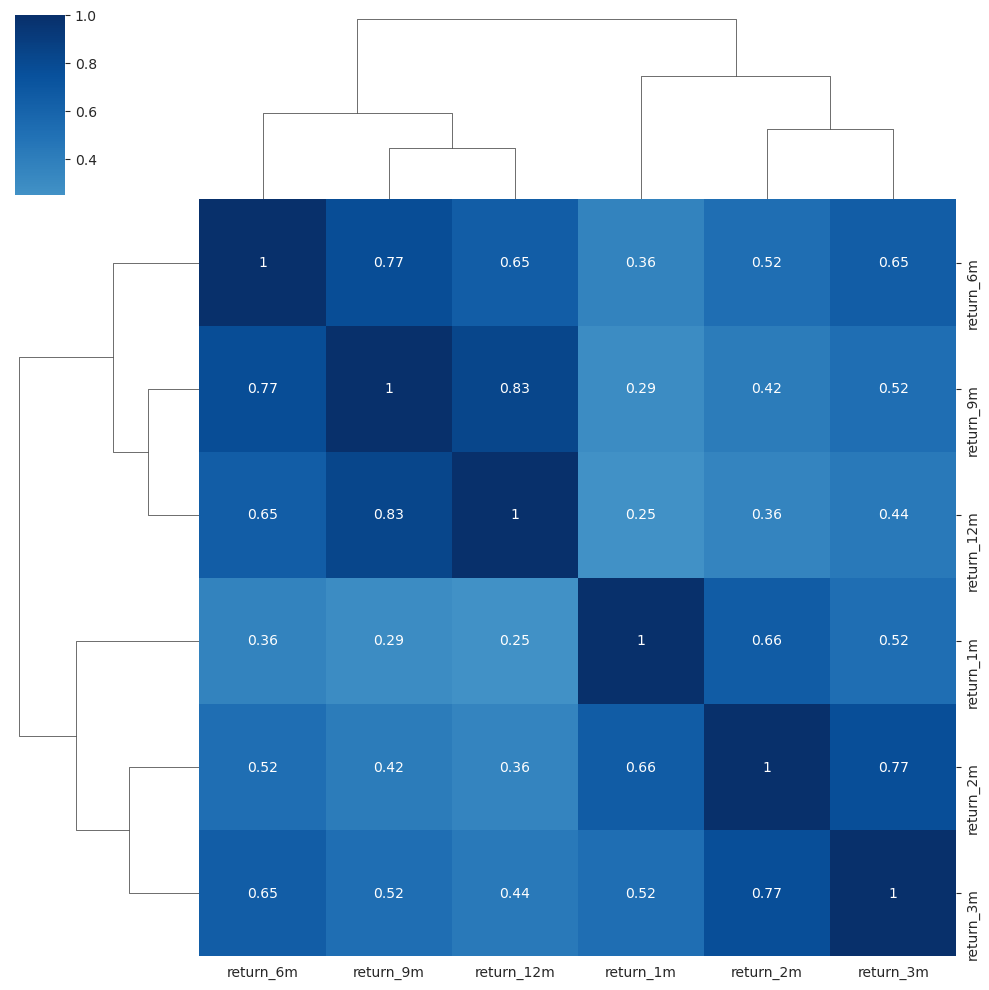

In [300]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')

In [301]:
data.index.get_level_values(0).nunique()

459

## Create Rolling Factor Betas

In [302]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 119619 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2022-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     119619 non-null  float64
 1   SMB        119619 non-null  float64
 2   HML        119619 non-null  float64
 3   RMW        119619 non-null  float64
 4   CMA        119619 non-null  float64
 5   return_1m  119619 non-null  float64
dtypes: float64(6)
memory usage: 5.9+ MB


In [303]:
T = 24
betas = (factor_data.groupby(level=0,
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,109062.000000,109062.000000,109062.000000,109062.000000,109062.000000,119619.000000
mean,0.960494,0.133337,0.009525,-0.018210,0.048830,1.033897
std,0.631519,0.844242,1.067214,1.266721,1.456241,2.188716
min,-3.141591,-4.624049,-9.367835,-17.395163,-12.236988,-25.627865
25%,0.583051,-0.382312,-0.589972,-0.688630,-0.741650,0.000000
50%,0.940837,0.099071,-0.007063,0.050153,0.054052,0.938424
75%,1.312563,0.602964,0.598287,0.726317,0.866319,2.262619
max,7.220220,6.168560,7.852495,7.537993,9.495415,16.554844


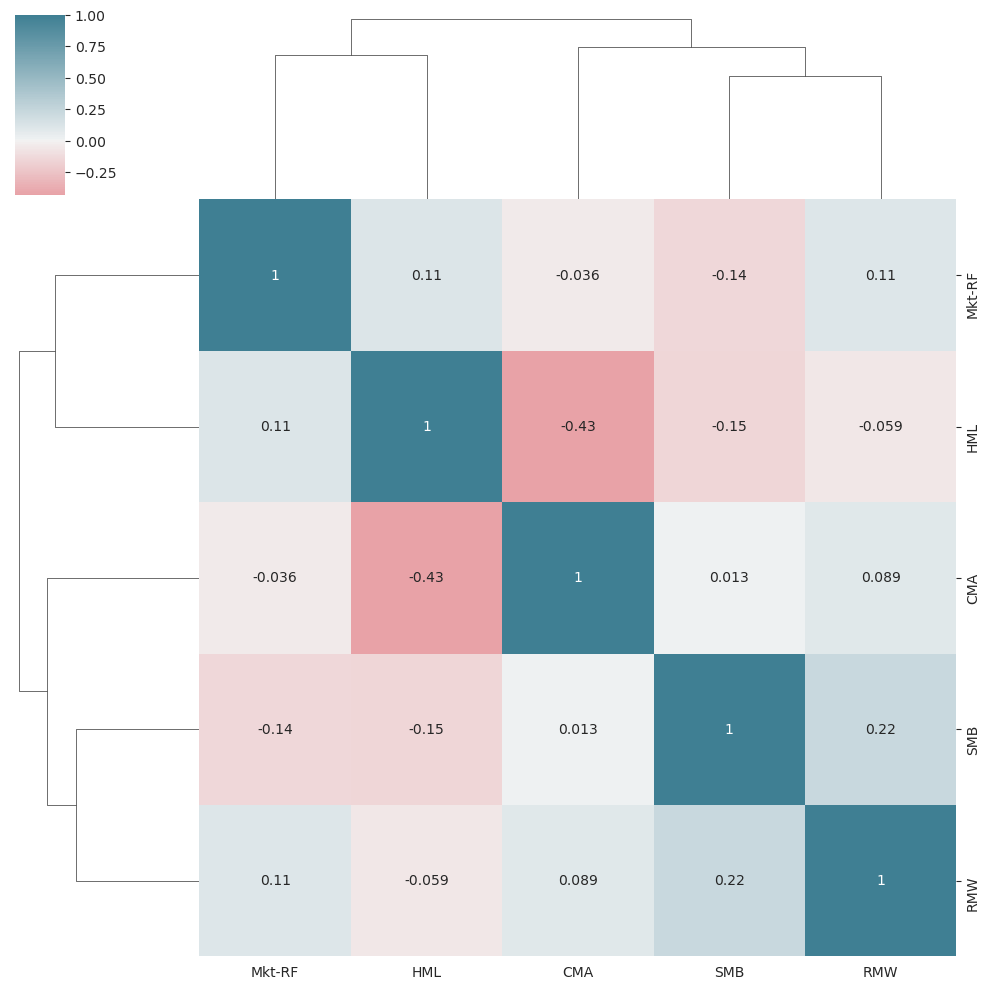

In [304]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

In [305]:
data = (data
        .join(betas
              .groupby(level=0)
              .shift()))
              
# impute means for rolling factor betas
data.loc[:, factors] = data.groupby(level=0)[factors].apply(lambda x: x.fillna(x.mean()))

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181871 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   181871 non-null  float64
 1   return_2m   181871 non-null  float64
 2   return_3m   181871 non-null  float64
 3   return_6m   181871 non-null  float64
 4   return_9m   181871 non-null  float64
 5   return_12m  181871 non-null  float64
 6   Mkt-RF      181871 non-null  float64
 7   SMB         181871 non-null  float64
 8   HML         181871 non-null  float64
 9   RMW         181871 non-null  float64
 10  CMA         181871 non-null  float64
dtypes: float64(11)
memory usage: 20.0+ MB


In [306]:
# add momentum factors 
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [307]:
# add date indicators
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [308]:
# add lagged returns
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level=0).return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181871 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      181871 non-null  float64
 1   return_2m      181871 non-null  float64
 2   return_3m      181871 non-null  float64
 3   return_6m      181871 non-null  float64
 4   return_9m      181871 non-null  float64
 5   return_12m     181871 non-null  float64
 6   Mkt-RF         181871 non-null  float64
 7   SMB            181871 non-null  float64
 8   HML            181871 non-null  float64
 9   RMW            181871 non-null  float64
 10  CMA            181871 non-null  float64
 11  momentum_2     181871 non-null  float64
 12  momentum_3     181871 non-null  float64
 13  momentum_6     181871 non-null  float64
 14  momentum_9     181871 non-null  float64
 15  momentum_12    181871 non

## Create Target: holding period returns

In [309]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level=0)[f'return_{t}m'].shift(-t)

In [310]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
  date                                                                
A 2001-02-28  -0.146393   0.040965  -0.023318  -0.243399  -0.183702   
  2001-03-31   0.269446   0.044722   0.018843  -0.146393  -0.183702   
  2001-04-30  -0.140220  -0.087247  -0.098191   0.269446   0.040965   
  2001-05-31  -0.031009  -0.076413  -0.075527  -0.140220   0.044722   
  2001-06-30  -0.119689  -0.097013  -0.151866  -0.031009  -0.087247   
  2001-07-31  -0.073753  -0.173365  -0.080114  -0.119689  -0.076413   
  2001-08-31  -0.243399  -0.083278   0.009594  -0.073753  -0.097013   
  2001-09-30   0.139135   0.181055   0.134010  -0.243399  -0.173365   
  2001-10-31   0.224517   0.131456   0.108695   0.139135  -0.083278   
  2001-11-30   0.045467   0.054959   0.045339   0.224517   0.181055   

              return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
  date                                                                
A 2001-02-28  -0.116421      -0.003653       0.049101       0.126858  
  2001-03-31  -0.151866      -0.243399      -0.003653       0.049101  
  2001-04-30  -0.105747      -0.146393      -0.243399      -0.003653  
  2001-05-31  -0.023318       0.269446      -0.146393      -0.243399  
  2001-06-30   0.018843      -0.140220       0.269446      -0.146393  
  2001-07-31  -0.098191      -0.031009      -0.140220       0.269446  
  2001-08-31  -0.075527      -0.119689      -0.031009      -0.140220  
  2001-09-30  -0.151866      -0.073753      -0.119689      -0.031009  
  2001-10-31  -0.080114      -0.243399      -0.073753      -0.119689  
  2001-11-30   0.009594       0.139135      -0.243399      -0.073753

In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181871 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      181871 non-null  float64
 1   return_2m      181871 non-null  float64
 2   return_3m      181871 non-null  float64
 3   return_6m      181871 non-null  float64
 4   return_9m      181871 non-null  float64
 5   return_12m     181871 non-null  float64
 6   Mkt-RF         181871 non-null  float64
 7   SMB            181871 non-null  float64
 8   HML            181871 non-null  float64
 9   RMW            181871 non-null  float64
 10  CMA            181871 non-null  float64
 11  momentum_2     181871 non-null  float64
 12  momentum_3     181871 non-null  float64
 13  momentum_6     181871 non-null  float64
 14  momentum_9     181871 non-null  float64
 15  momentum_12    181871 non

In [312]:
a = []
for i in range(len(stocks)):
    year = stocks.IPODate[i][0:4]
    a.append(year)

a = pd.Series(a, name = 'IPOYear', index = stocks.index)
stocks = stocks.join(a)
stocks = stocks.drop('IPODate', axis = 1)

In [313]:
stocks.head()

,Sector,MarketCapitalization,IPOYear
AAPL,Technology,2349235699712,1980
MSFT,Technology,1880825004032,1986
AMZN,Consumer Cyclical,969189687296,1997
GOOGL,Communication Services,1209774637056,2004
TSLA,Consumer Cyclical,624498442240,2010


In [314]:
## create age proxy using quintiles
data = (data
        .join(pd.qcut(stocks['IPOYear'].astype('int64'), q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age'), on = data.index.get_level_values(0)))
data.age = data.age.fillna(-1)

In [315]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, AAPL to NWS
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Sector                503 non-null    object
 1   MarketCapitalization  503 non-null    object
 2   IPOYear               503 non-null    object
dtypes: object(3)
memory usage: 31.9+ KB


In [316]:
## create dynamic size proxy
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values(0).unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 722 entries, 2023-02-28 to 1963-01-31
Columns: 459 entries, A to ZION
dtypes: float64(459)
memory usage: 2.5 MB


In [317]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'MarketCapitalization'])).dropna(axis=1, how='all')

In [318]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

In [319]:
data.index

MultiIndex([(   'A', '2000-11-30'),
            (   'A', '2000-12-31'),
            (   'A', '2001-01-31'),
            (   'A', '2001-02-28'),
            (   'A', '2001-03-31'),
            (   'A', '2001-04-30'),
            (   'A', '2001-05-31'),
            (   'A', '2001-06-30'),
            (   'A', '2001-07-31'),
            (   'A', '2001-08-31'),
            ...
            ('ZION', '2022-05-31'),
            ('ZION', '2022-06-30'),
            ('ZION', '2022-07-31'),
            ('ZION', '2022-08-31'),
            ('ZION', '2022-09-30'),
            ('ZION', '2022-10-31'),
            ('ZION', '2022-11-30'),
            ('ZION', '2022-12-31'),
            ('ZION', '2023-01-31'),
            ('ZION', '2023-02-28')],
           names=[None, 'date'], length=181871)

## Combine data

In [321]:
data = data.join(stocks[['Sector']], on = data.index.get_level_values(0))
data.Sector = data.Sector.fillna('Unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181871 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      181871 non-null  float64
 1   return_2m      181871 non-null  float64
 2   return_3m      181871 non-null  float64
 3   return_6m      181871 non-null  float64
 4   return_9m      181871 non-null  float64
 5   return_12m     181871 non-null  float64
 6   Mkt-RF         181871 non-null  float64
 7   SMB            181871 non-null  float64
 8   HML            181871 non-null  float64
 9   RMW            181871 non-null  float64
 10  CMA            181871 non-null  float64
 11  momentum_2     181871 non-null  float64
 12  momentum_3     181871 non-null  float64
 13  momentum_6     181871 non-null  float64
 14  momentum_9     181871 non-null  float64
 15  momentum_12    181871 non

## Store Data

In [322]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index())
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../00_data/assets_v1.h5
/engineered_features                 frame        (shape->[181871,33])
/fred/assets                         frame        (shape->[6037,4])   
/sp500/stocks                        frame        (shape->[503,8])    
/sp500/stooq                         frame        (shape->[17700,5])  
/stocks/base_fundementals            series       (shape->[1])        
/stocks/prices/daily                 frame        (shape->[4003688,6])


## Create Dummy Variables

In [324]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'Sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181871 entries, ('A', Timestamp('2000-11-30 00:00:00', freq='M')) to ('ZION', Timestamp('2023-02-28 00:00:00', freq='M'))
Columns: 127 entries, return_1m to Utilities
dtypes: float64(28), uint8(99)
memory usage: 60.8+ MB
